In [1]:
import cv2
import dlib
import pickle
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import urllib.request

from sklearn import metrics
from scipy.spatial import distance
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt
from tqdm import tqdm, tqdm_pandas
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import re
import gdown
import keras

from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import Adam 
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam, SGD
from keras.regularizers import l2
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import load_model

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import optimizers

warnings.filterwarnings("ignore")

def model_to_string(model):
    import re
    stringlist = []
    model.summary(print_fn=lambda x: stringlist.append(x))
    sms = "\n".join(stringlist)
    sms = re.sub('_\d\d\d', '', sms)
    sms = re.sub('_\d\d', '', sms)
    sms = re.sub('_\d', '', sms)
    return sms

### Getting the csv data loaded
dataset_url = 'https://drive.google.com/uc?id=1xFiYsULlQWWmi2Ai0fHjtApniP5Pscuf'
dataset_path = './ferdata.csv'
gdown.download(dataset_url, dataset_path, True)

### Getting the Dlib Shape predictor!
dlibshape_url = 'https://drive.google.com/uc?id=17D3D89Gke6i5nKOvmsbPslrGg5rVgOwg'
dlibshape_path = './shape_predictor_68_face_landmarks.dat'
gdown.download(dlibshape_url, dlibshape_path, True)

### Getting the Xpure loaded
pureX_url = 'https://drive.google.com/uc?id=1CglpXodenZVrkaZehLtfykfQv8dcnfO9'
pureX_path = './pureX.npy'
gdown.download(pureX_url, pureX_path, True)

### Getting the Xdata loaded
dataX_url = 'https://drive.google.com/uc?id=1sIJGxUM6rNBcWxucs6iynDepeKU1Q56p'
dataX_path = './dataX.npy'
gdown.download(dataX_url, dataX_path, True)

### Getting the Ydata loaded
dataY_url = 'https://drive.google.com/uc?id=1Rfr0OP-hZO_UZfuOyMNR2RjNRAro85zE'
dataY_path = './dataY.npy'
gdown.download(dataY_url, dataY_path, True)

print("Data Downloaded!")

'''
Plots the confusion Matrix and saves it
'''
def plot_confusion_matrix(y_true, y_predicted):
    cm = metrics.confusion_matrix(y_true, y_predicted)
    print("Plotting the Confusion Matrix")
    labels = list(label_map.values())
    df_cm = pd.DataFrame(cm, index=labels, columns=labels)
    fig = plt.figure()
    res = sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g')
    plt.yticks([0.5, 1.5, 2.5, 3.5, 4.5], labels, va='center')
    plt.title('Confusion Matrix - TestData')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    plt.close()

def plot_graphs(history, best):
    plt.figure(figsize=[10, 4])
    # summarize history for accuracy
    plt.subplot(121)
    plt.plot(history.history['accuracy'])  # Change 'acc' to 'accuracy'
    plt.plot(history.history['val_accuracy'])  # Change 'val_acc' to 'val_accuracy'
    plt.title('model accuracy across training\n best accuracy of %.02f' % best[1])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')

    # summarize history for loss
    plt.subplot(122)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss across training\n best loss of %.02f' % best[0])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

# Integer to Label Mapping
label_map = {0: "ANGRY", 1: "HAPPY", 2: "SAD", 3: "SURPRISE", 4: "NEUTRAL"}

# Load the 68 face Landmark file
predictor = dlib.shape_predictor('./shape_predictor_68_face_landmarks.dat')

"""
Returns facial landmarks for the given input image path
"""
def get_landmarks(image):
    #:type image : cv2 object
    #:rtype landmarks : list of tuples where each tuple represents 
    #                  the x and y co-ordinates of facial keypoints

    # Bounding Box co-ordinates around the face(Training data is 48*48(cropped faces))
    rects = [dlib.rectangle(left=1, top=1, right=47, bottom=47)]

    # Detect the Faces within the image
    landmarks = [(p.x, p.y) for p in predictor(image, rects[0]).parts()]
    return image, landmarks

"""
Display image with its Facial Landmarks
"""
def image_landmarks(image, face_landmarks):
    """
    :type image_path : str
    :type face_landmarks : list of tuples where each tuple represents 
                       the x and y co-ordinates of facial keypoints
    :rtype : None
    """
    radius = -4
    circle_thickness = 1
    image_copy = image.copy()
    for (x, y) in face_landmarks:
        cv2.circle(image_copy, (x, y), circle_thickness, (255, 0, 0), radius)

    plt.imshow(image_copy, interpolation='nearest')
    plt.show()

"""
Computes euclidean distance between 68 Landmark Points for our features
e_dist is a list of features that will go into our model.
Each feature is a distance between two landmark points, and every pair of points
must have a feature.
"""
def landmarks_edist(face_landmarks):
    e_dist = []
    for i in range(len(face_landmarks)):
        for j in range(len(face_landmarks)):
            if i != j:
                e_dist.append(distance.euclidean(face_landmarks[i], face_landmarks[j]))
    return e_dist

def compare_learning(mlp, lm, cnn, vgg):  # there's one model missing: MLP from pixels
    # summarize history for accuracy
    plt.plot(vgg.history['val_accuracy'],)  # Change 'val_acc' to 'val_accuracy'
    plt.plot(cnn.history['val_accuracy'])  # Change 'val_acc' to 'val_accuracy'
    plt.plot(mlp.history['val_accuracy'],)  # Change 'val_acc' to 'val_accuracy'
    plt.plot(lm.history['val_accuracy'])  # Change 'val_acc' to 'val_accuracy'
    plt.ylabel('validation accuracy')
    plt.xlabel('epoch')
    plt.legend(['cnn_transfer', 'cnn_scratch', 'mlp_pixels', 'mlp_landmarks'], bbox_to_anchor=[1, 1])
    plt.xticks(range(0, epochs + 1, 5), range(0, epochs + 1, 5))
    plt.show()

<>:47: SyntaxWarning: invalid escape sequence '\d'
<>:48: SyntaxWarning: invalid escape sequence '\d'
<>:49: SyntaxWarning: invalid escape sequence '\d'
<>:47: SyntaxWarning: invalid escape sequence '\d'
<>:48: SyntaxWarning: invalid escape sequence '\d'
<>:49: SyntaxWarning: invalid escape sequence '\d'
/var/folders/61/fmmdx5z91s9_81y4wxnb3bdm0000gn/T/ipykernel_31189/1051343267.py:47: SyntaxWarning: invalid escape sequence '\d'
  sms = re.sub('_\d\d\d', '', sms)
/var/folders/61/fmmdx5z91s9_81y4wxnb3bdm0000gn/T/ipykernel_31189/1051343267.py:48: SyntaxWarning: invalid escape sequence '\d'
  sms = re.sub('_\d\d', '', sms)
/var/folders/61/fmmdx5z91s9_81y4wxnb3bdm0000gn/T/ipykernel_31189/1051343267.py:49: SyntaxWarning: invalid escape sequence '\d'
  sms = re.sub('_\d', '', sms)


Data Downloaded!


In [2]:
# training related  
epochs, batch_size = 20, 64
# testing related
test_ratio = .1
# categories to predict 
n_emotion_labels = 5 
# shape of images 
width, height = 48, 48

In [3]:
dataX_pixels = np.load('pureX.npy')
dataY_pixels = np.load('dataY.npy')

In [4]:
y_onehot = keras.utils.to_categorical(dataY_pixels, len(set(dataY_pixels)))

In [5]:
i_index = 12
print('The initial format was just a number, for example a "%d"'%dataY_pixels[i_index]) 
print('We convert this to a one hot encoding: ', y_onehot[i_index]) 
print('Both of these are different ways of representing "%s"'%label_map[dataY_pixels[i_index]])

The initial format was just a number, for example a "1"
We convert this to a one hot encoding:  [0. 1. 0. 0. 0.]
Both of these are different ways of representing "HAPPY"


In [6]:
# split Data into Train, Test (90-10)
X_train, X_test, y_train, y_test = train_test_split(dataX_pixels, y_onehot, test_size=test_ratio, random_state=42)

In [7]:
pixel_scaler = StandardScaler()
pixel_scaler.fit(X_train)
X_train = pixel_scaler.transform(X_train)
X_test = pixel_scaler.transform(X_test)

In [8]:
mlp_model = Sequential()
mlp_model.add(Dense(5120, activation='relu',kernel_initializer='glorot_normal', input_shape=( X_train.shape[1]   ,)))
mlp_model.add(Dropout(0.2))
mlp_model.add(Dense(512,kernel_initializer='glorot_normal', activation='relu'))
mlp_model.add(Dropout(0.2))
mlp_model.add(Dense(256,kernel_initializer='glorot_normal', activation='relu'))
mlp_model.add(Dropout(0.2))
mlp_model.add(Dense(n_emotion_labels, activation='softmax'))

In [13]:
# Compiling the model with SGD optimizer and categorical crossentropy loss
mlp_model.compile(loss=categorical_crossentropy, optimizer=SGD(learning_rate=0.001), metrics=['accuracy'])

# Saves the Best Model Based on Val Loss
checkpoint = ModelCheckpoint('best_mlp_model.keras', verbose=1, monitor='val_acc', save_best_only=True, mode='auto')

# Training the model
mlp_history = mlp_model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, 
                            callbacks=[checkpoint], validation_data=(X_test, y_test), shuffle=True)

Epoch 1/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.2510 - loss: 1.6786 - val_accuracy: 0.3230 - val_loss: 1.5150
Epoch 2/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.3060 - loss: 1.5587 - val_accuracy: 0.3550 - val_loss: 1.4757
Epoch 3/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.3369 - loss: 1.5214 - val_accuracy: 0.3815 - val_loss: 1.4545
Epoch 4/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - accuracy: 0.3479 - loss: 1.4884 - val_accuracy: 0.3935 - val_loss: 1.4367
Epoch 5/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.3730 - loss: 1.4552 - val_accuracy: 0.4050 - val_loss: 1.4242
Epoch 6/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.3833 - loss: 1.4361 - val_accuracy: 0.4025 - val_loss: 1.4127
Epoch 7/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.3916 - loss: 1.4233 - val_accuracy: 0.4150 - val_loss: 1.4012
Epoch 8/20
282/282 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.4065 - loss: 1.4028 - val_accu

In [14]:
mlp_performance = mlp_model.evaluate(X_test, y_test, batch_size=64)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4612 - loss: 1.3315


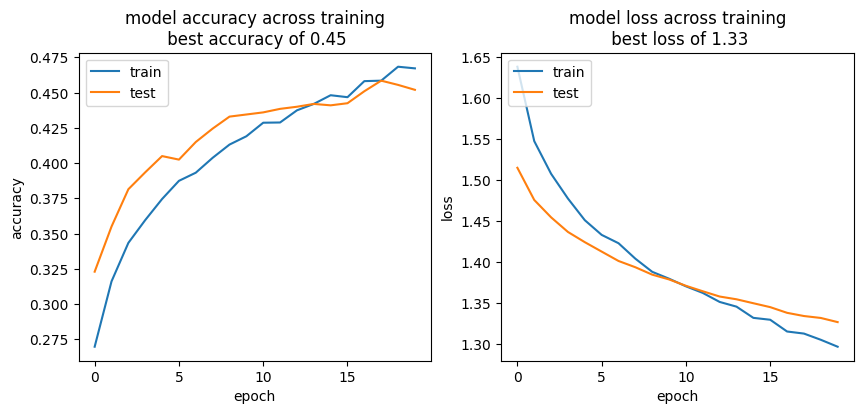

In [15]:
plot_graphs(mlp_history, mlp_performance); 

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Plotting the Confusion Matrix


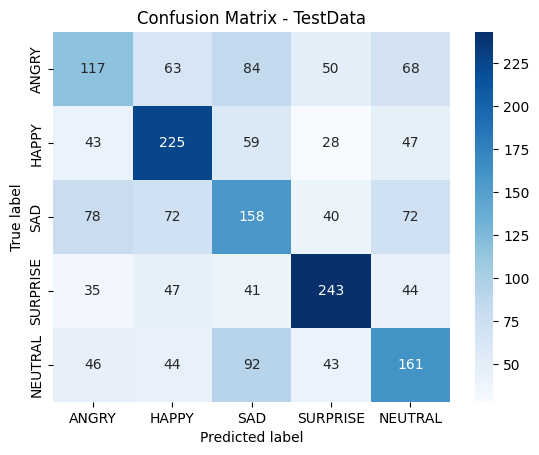

In [16]:
y_pred_prob = mlp_model.predict(X_test)

# Convert the class probabilities to class labels
y_pred = np.argmax(y_pred_prob, axis=1)

# Assuming y_test is one-hot encoded
y_true = np.argmax(y_test, axis=1)

# Plot the confusion matrix
plot_confusion_matrix(y_true, y_pred)